In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/pbs/home/c/cmurray/cluster_likelihood/')
import modules.simulation as simulation
import pyccl as ccl
import modules.summary_statistics.des_summary_statistics as ss

import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

/pbs/home/c/cmurray/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Run a simple and small SBI thing.

In [2]:
simulator = simulation.UniverseSimulator( ss.counts_and_mean_mass ,  config_path = '/pbs/home/c/cmurray/cluster_likelihood/config/capish.ini' )

In [3]:
test = simulator.run_simulation( [ 0.3 , 0.8 , 1.24 , 0.74 ])

In [4]:
def summary_statistic_to_sensible_format( summary_statistic ):

    sim_n_clusters = summary_statistic[:12].reshape(4, 3)
    sim_mwl_mean = summary_statistic[12:].reshape(4, 3)
    
    return sim_n_clusters, sim_mwl_mean

(array([13.6, 13.8, 14. , 14.2, 14.4, 14.6, 14.8, 15. ]),
 [Text(0, 13.600000000000001, '13.6'),
  Text(0, 13.8, '13.8'),
  Text(0, 14.000000000000002, '14.0'),
  Text(0, 14.200000000000001, '14.2'),
  Text(0, 14.400000000000002, '14.4'),
  Text(0, 14.600000000000001, '14.6'),
  Text(0, 14.8, '14.8'),
  Text(0, 15.000000000000002, '15.0')])

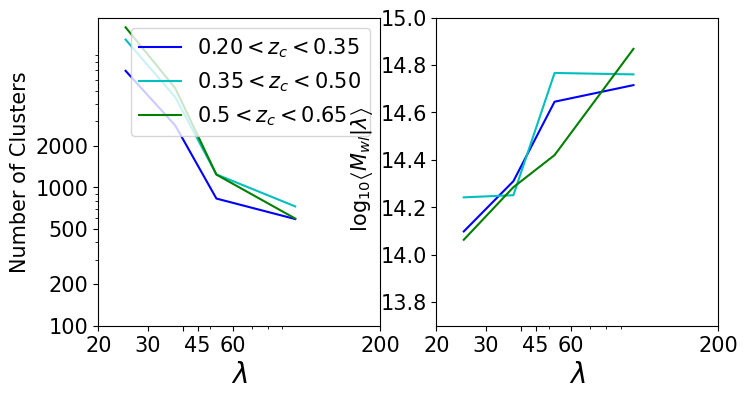

In [5]:
# Set the figure size
plt.figure(figsize=(8, 4 ) )
# Subplot 1: Number of clusters
plt.subplot(121)
plt.plot( ss.richness_cents, summary_statistic_to_sensible_format( test )[0].T[0], 'b-', label='$ 0.20 < z_c < 0.35 $')
plt.plot( ss.richness_cents, summary_statistic_to_sensible_format( test )[0].T[1], 'c-', label='$ 0.35 < z_c < 0.50 $')
plt.plot( ss.richness_cents, summary_statistic_to_sensible_format( test )[0].T[2], 'g-', label='$ 0.5 < z_c < 0.65$')

# plt.plot( 0 , 0 , 'k-', alpha = 0.5 , label ='DES Y1 observation')
# plt.plot( 0 , 0 , 'k--', alpha = 0.5 , label ='MPE with SBI')

plt.xscale('log')
plt.yscale('log')
plt.yticks([100, 200, 500, 1000, 2000], labels=[100, 200, 500, 1000, 2000])
# plt.xlim(20, 200)
# plt.ylim(50, 2200)
plt.xlabel(r'$\lambda$' , fontsize = 20)
plt.ylabel('Number of Clusters' , fontsize = 15)
plt.legend(loc='upper right' , fontsize = 15 )
plt.xticks( ticks = [ 20 , 30 , 40 , 45 , 60 , 200 ],
            labels = [ 20 , 30 , None , 45 , 60 , 200 ] , fontsize = 15 )
plt.yticks( fontsize = 15 )

# Subplot 2: Mean MWL
plt.subplot(122)
plt.plot( ss.richness_cents, summary_statistic_to_sensible_format( test )[1].T[0], 'b-', label='$ 0.20 < z_c < 0.35 $')
plt.plot( ss.richness_cents, summary_statistic_to_sensible_format( test )[1].T[1], 'c-', label='$ 0.35 < z_c < 0.50 $')
plt.plot( ss.richness_cents, summary_statistic_to_sensible_format( test )[1].T[2], 'g-', label='$ 0.5 < z_c < 0.65$')


plt.xscale('log')
# plt.xlim(20, 220)
plt.ylim(13.7, 15)
plt.xlabel(r'$\lambda$' , fontsize = 20)
plt.ylabel(r' log$_{10} \left< M_{wl} | \lambda \right>$' , fontsize = 15)
plt.xticks( ticks = [ 20 , 30 , 40 , 45 , 60 , 200 ],
            labels = [ 20 , 30 , None , 45 , 60 , 200 ] , fontsize = 15 )
plt.yticks( fontsize = 15 )

In [ ]:
# 0.3 , 0.8 , 1.24 , 0.74 

In [15]:
# make sure that this is the correct size
prior = utils.BoxUniform( low = [ 0.05 , 0.5  , 1 , 0.5 ] ,
                          high = [ 1.0 , 1.5  , 2 , 1.0  ] )


In [ ]:
des_posterior = infer( simulator.run_simulation ,
                       prior,
                       method = "SNPE",
                       num_simulations = 500 ,
                       num_workers = 20 )

Running 500 simulations in 500 batches.:  28%|██▊       | 140/500 [03:14<07:54,  1.32s/it]

In [10]:
# get posterior
nsamples = 50000
# samples_sim = pinocchio_posterior_calculator.sample( (nsamples,), x = sim_obs )
samples_test = des_posterior.sample( (nsamples,), x = test )

Drawing 50000 posterior samples: 50248it [00:12, 4075.85it/s]                           


In [12]:
import corner

In [14]:
samples_test.shape

torch.Size([50000, 5])

IndexError: list index out of range

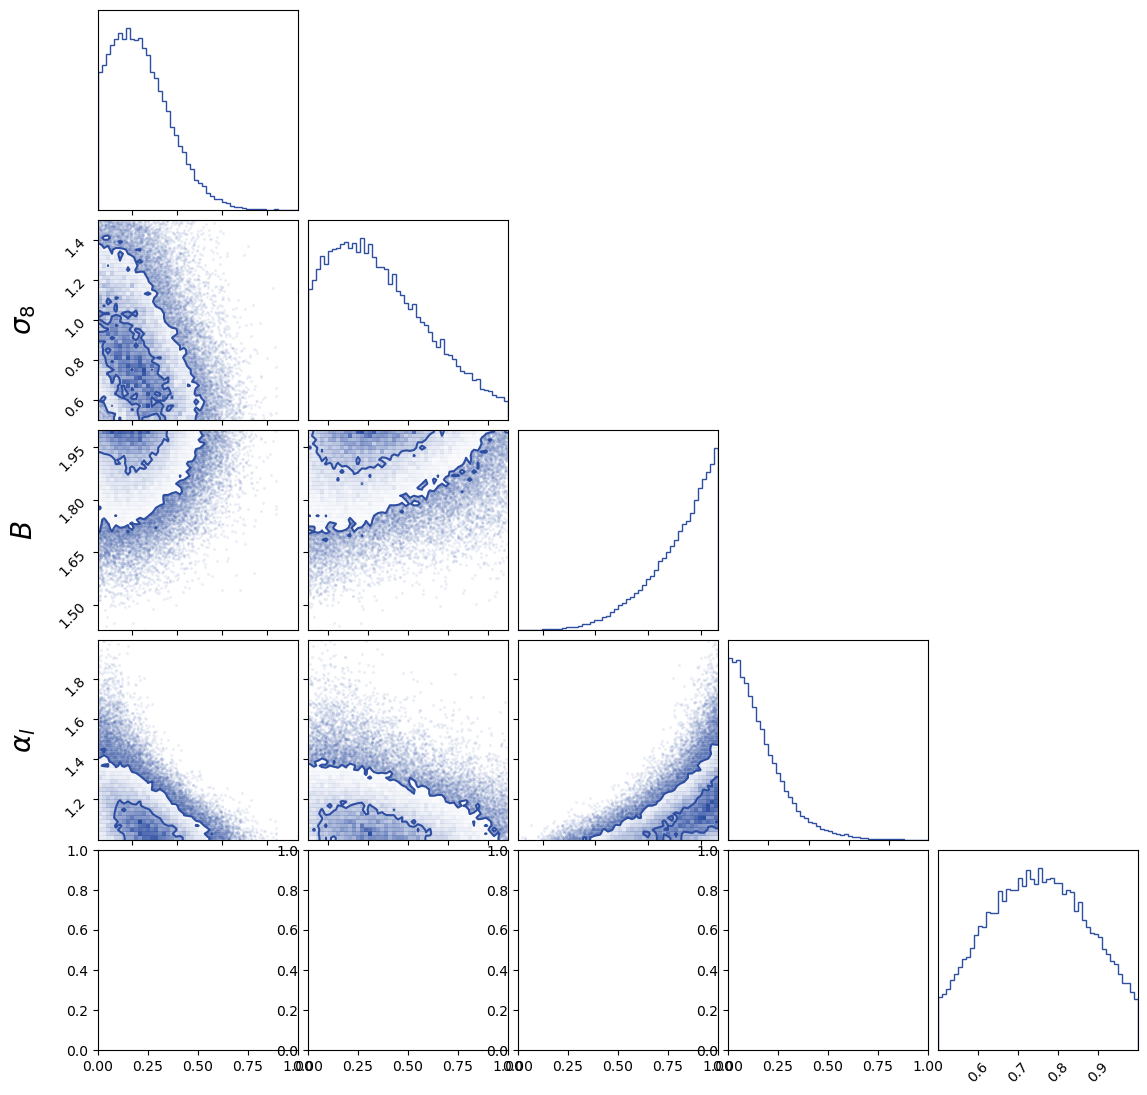

In [13]:
labels = [r'$\Omega_m$' , r'$\sigma_8$' , r'$B$' , r'$\alpha_l$' ]
truths = [ 0.3 , 0.8 , 1.24 , 0.74]


# Create the corner plot for samples (now 5D)
figure = corner.corner(samples_test.numpy(), 
                       levels=[0.393, 0.86],  
                       bins=50, 
                       hist_kwargs={'density': True},
                       labels=labels,
                       color='#2d4ea1',
                       truths=truths,
                       truth_color='k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25})

# # Add the alt_samples to the same corner plot
# corner.corner(samples_pin_SSC.numpy(), fig=figure, 
#                        levels=[0.393, 0.86],  
#                        bins=50, 
#                        hist_kwargs={'density': True},
#                        labels=labels,
#                        color='#880a94',
#                        truths=truths,
#                        truth_color='k',
#                        label_kwargs={"fontsize": 20},
#                        title_kwargs={"fontsize": 25})

# corner.corner( data['flat_chains'] , fig=figure, 
#                        levels=[0.393, 0.86],  
#                        bins=50, 
#                        hist_kwargs={'density': True},
#                        labels=labels,
#                        color='#159939',
#                        truths=truths,
#                        truth_color='k',
#                        label_kwargs={"fontsize": 20},
#                        title_kwargs={"fontsize": 25})

# Plot the legends
plt.plot( [  0 ] , [ 0 ] , color = '#2d4ea1' , label = 'Poisson ')
# plt.plot( [  0 ] , [ 0 ] , color = '#880a94' , label = 'Poisson + SSC')
# plt.plot( [  0 ] , [ 0 ] , color = '#159939' , label = 'Likelihood')
plt.legend(loc="upper right")